# Ticket To Ride Network Analysis (Design Principles)

This notebook reads `board.json`, computes network statistics, and provides tools to edit/save the board.


In [8]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

board = json.loads(Path("board.json").read_text())
places = {p["id"]: p for p in board.get("places", [])}
roads = board.get("roads", [])

def save_board(path="board.json"):
    Path(path).write_text(json.dumps(board, indent=2))

print(f"Loaded {len(places)} cities, {len(roads)} routes")


Loaded 28 cities, 50 routes


In [9]:
# Build adjacency and edge weights
adj = {pid: set() for pid in places}
edges = []  # (a, b, weight)
for r in roads:
    ids = r.get("placeIds", [])
    if len(ids) != 2:
        continue
    a, b = ids
    w = int(r.get("spaceAmount", 0) or 0)
    adj.setdefault(a, set()).add(b)
    adj.setdefault(b, set()).add(a)
    edges.append((a, b, w))

degrees = {pid: len(neigh) for pid, neigh in adj.items()}
edge_weights = [w for _, _, w in edges if w > 0]

print("Degree range:", (min(degrees.values()), max(degrees.values())))
print("Edge weight range:", (min(edge_weights), max(edge_weights)) if edge_weights else (0, 0))


Degree range: (3, 5)
Edge weight range: (2, 8)


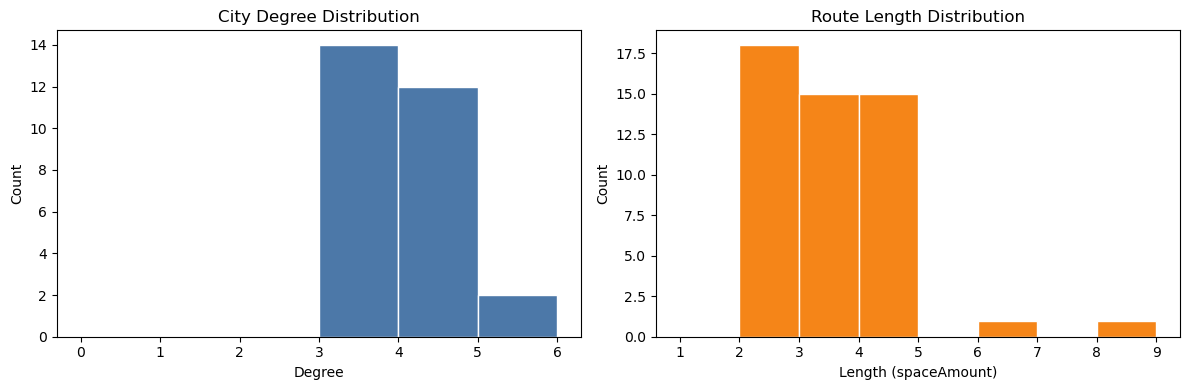

In [10]:
# Histograms: degree distribution and route lengths
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(degrees.values(), bins=range(0, max(degrees.values() or [0]) + 2),
             color="#4c78a8", edgecolor="white")
axes[0].set_title("City Degree Distribution")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Count")

axes[1].hist(edge_weights, bins=range(1, max(edge_weights or [1]) + 2),
             color="#f58518", edgecolor="white")
axes[1].set_title("Route Length Distribution")
axes[1].set_xlabel("Length (spaceAmount)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [11]:
# Shortest-path distances and eccentricity (unweighted graph)
from collections import deque

def bfs_distances(start):
    dist = {start: 0}
    q = deque([start])
    while q:
        cur = q.popleft()
        for nxt in adj.get(cur, []):
            if nxt not in dist:
                dist[nxt] = dist[cur] + 1
                q.append(nxt)
    return dist

eccentricity = {}
for pid in places:
    d = bfs_distances(pid)
    if len(d) != len(places):
        eccentricity[pid] = None
    else:
        eccentricity[pid] = max(d.values())

ecc_values = [v for v in eccentricity.values() if v is not None]
radius = min(ecc_values) if ecc_values else None
diameter = max(ecc_values) if ecc_values else None
center = [places[pid]["name"] for pid, v in eccentricity.items() if v == radius]
periphery = [places[pid]["name"] for pid, v in eccentricity.items() if v == diameter]

print("Radius:", radius)
print("Diameter:", diameter)
print("Center cities:", center)
print("Periphery cities:", periphery)


Radius: 4
Diameter: 5
Center cities: ['Riverside', 'Hilo', 'Philadelphia', 'Washington DC', 'Seoul', 'Busan', 'Istanbul', 'Yerevan', 'Almaty', 'Tashkent', 'Mandalay', 'Shanghai']
Periphery cities: ['Fairbanks', 'Berkeley', 'Long Beach', 'Fort Worth', 'Columbus', 'Boston', 'Daegu', 'Goesan', 'Tokyo', 'Dili', 'Izmir', 'Moscow', 'Tbilisi', 'Yangon', 'Mawlamyine', 'Beijing']


In [12]:
# Degree centrality (simple)
n = len(places)
degree_centrality = {pid: (deg / (n - 1) if n > 1 else 0) for pid, deg in degrees.items()}

top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top degree centrality:")
for pid, val in top_degree:
    print(places[pid]["name"], round(val, 3))


Top degree centrality:
Washington DC 0.185
Almaty 0.185
Fairbanks 0.148
Berkeley 0.148
Riverside 0.148
Long Beach 0.148
Hilo 0.148
Columbus 0.148
Boston 0.148
Philadelphia 0.148


In [13]:
# Helper: update route length or colors by city names
def find_place_id_by_name(name):
    for pid, p in places.items():
        if p["name"] == name:
            return pid
    return None

def update_route(name_a, name_b, space_amount=None, colours=None):
    a_id = find_place_id_by_name(name_a)
    b_id = find_place_id_by_name(name_b)
    if a_id is None or b_id is None:
        raise ValueError("City not found")
    for r in roads:
        ids = r.get("placeIds", [])
        if len(ids) == 2 and {ids[0], ids[1]} == {a_id, b_id}:
            if space_amount is not None:
                r["spaceAmount"] = int(space_amount)
            if colours is not None:
                r["lanes"] = [{"id": i + 1, "colour": c} for i, c in enumerate(colours)]
            return r
    raise ValueError("Route not found")

# Example usage:
# update_route("Fairbanks", "Columbus", space_amount=4, colours=["white", "blue"])


In [14]:
# Mark important cities and routes to bias balancing
import ipywidgets as widgets
from IPython.display import display

important_city_ids = set()
important_route_keys = set()  # frozenset({a_id, b_id})

city_options = [(p["name"], pid) for pid, p in places.items()]
city_options = sorted(city_options, key=lambda x: x[0])

route_options = []
for r in roads:
    ids = r.get("placeIds", [])
    if len(ids) != 2:
        continue
    a, b = ids
    name_a = places.get(a, {}).get("name", str(a))
    name_b = places.get(b, {}).get("name", str(b))
    route_options.append((f"{name_a} - {name_b}", frozenset({a, b})))
route_options = sorted(route_options, key=lambda x: x[0])

city_selector = widgets.SelectMultiple(description="Cities", options=city_options, rows=8)
route_selector = widgets.SelectMultiple(description="Routes", options=route_options, rows=8)

mark_city = widgets.Button(description="Mark City Important", button_style="warning")
unmark_city = widgets.Button(description="Unmark City", button_style="")
mark_route = widgets.Button(description="Mark Route Important", button_style="warning")
unmark_route = widgets.Button(description="Unmark Route", button_style="")

boost_city = widgets.Button(description="Boost City Degree", button_style="info")
boost_route = widgets.Button(description="Boost Route Weight", button_style="info")

output_importance = widgets.Output()


def refresh_status():
    with output_importance:
        output_importance.clear_output()
        city_names = [places[pid]["name"] for pid in important_city_ids]
        route_names = []
        for key in important_route_keys:
            a, b = list(key)
            route_names.append(f"{places[a]['name']} - {places[b]['name']}")
        print("Important cities:", sorted(city_names))
        print("Important routes:", sorted(route_names))


def handle_mark_city(_):
    important_city_ids.update(city_selector.value)
    refresh_status()


def handle_unmark_city(_):
    for pid in list(city_selector.value):
        important_city_ids.discard(pid)
    refresh_status()


def handle_mark_route(_):
    important_route_keys.update(route_selector.value)
    refresh_status()


def handle_unmark_route(_):
    for key in list(route_selector.value):
        important_route_keys.discard(key)
    refresh_status()


def boost_city_degree():
    # Add one extra connection for each selected important city if possible
    for pid in city_selector.value:
        candidates = [other for other in places.keys() if other != pid]
        random.shuffle(candidates)
        for other in candidates:
            exists = any(len(r.get("placeIds", [])) == 2 and {r["placeIds"][0], r["placeIds"][1]} == {pid, other} for r in roads)
            if not exists:
                roads.append({
                    "id": max((r.get("id", 0) for r in roads), default=0) + 1,
                    "placeIds": [pid, other],
                    "spaceAmount": 3,
                    "lanes": [{"id": 1, "colour": "grey"}],
                    "curvature": 0,
                })
                break


def handle_boost_city(_):
    boost_city_degree()
    rebuild_graph()
    refresh_status()


def handle_boost_route(_):
    for key in route_selector.value:
        for r in roads:
            ids = r.get("placeIds", [])
            if len(ids) == 2 and frozenset(ids) == key:
                r["spaceAmount"] = max(int(r.get("spaceAmount", 0) or 0), 4)
                r["lanes"] = [
                    {"id": 1, "colour": "red"},
                    {"id": 2, "colour": "blue"},
                ]
                break
    rebuild_graph()
    refresh_status()


mark_city.on_click(handle_mark_city)
unmark_city.on_click(handle_unmark_city)
mark_route.on_click(handle_mark_route)
unmark_route.on_click(handle_unmark_route)
boost_city.on_click(handle_boost_city)
boost_route.on_click(handle_boost_route)

refresh_status()

ui = widgets.VBox([
    widgets.HTML("<b>Importance Controls</b>"),
    city_selector,
    widgets.HBox([mark_city, unmark_city]),
    boost_city,
    route_selector,
    widgets.HBox([mark_route, unmark_route]),
    boost_route,
])

display(ui, output_importance)


Output()

In [ ]:
# Fix buttons to nudge the board toward the design principles
import random
import ipywidgets as widgets
from IPython.display import display

output = widgets.Output()

button_rebalance_weights = widgets.Button(description="Rebalance Route Lengths", button_style="info")
button_fix_degrees = widgets.Button(description="Normalize City Degrees", button_style="warning")
button_apply_all = widgets.Button(description="Apply All Fixes", button_style="primary")
button_save = widgets.Button(description="Save board.json", button_style="success")


def rebuild_graph():
    global adj, edges, degrees, edge_weights
    adj = {pid: set() for pid in places}
    edges = []
    for r in roads:
        ids = r.get("placeIds", [])
        if len(ids) != 2:
            continue
        a, b = ids
        w = int(r.get("spaceAmount", 0) or 0)
        adj.setdefault(a, set()).add(b)
        adj.setdefault(b, set()).add(a)
        edges.append((a, b, w))
    degrees = {pid: len(neigh) for pid, neigh in adj.items()}
    edge_weights = [w for _, _, w in edges if w > 0]


def rebalance_route_lengths():
    # Keep important routes at higher weights
    # Target distribution from design principles (scaled to current edge count)
    target = {2: 33, 4: 26, 3: 25, 6: 2, 8: 1}
    total = sum(target.values())
    m = len(roads)
    if m == 0:
        return

    counts = {k: int(round(m * v / total)) for k, v in target.items()}
    # Adjust counts to match m exactly
    while sum(counts.values()) < m:
        counts[2] += 1
    while sum(counts.values()) > m:
        for k in sorted(counts, key=counts.get, reverse=True):
            if counts[k] > 0:
                counts[k] -= 1
                break

    weights = []
    for w, c in counts.items():
        weights.extend([w] * c)
    random.shuffle(weights)

    # Preserve important routes with higher minimum weight
    for r in roads:
        ids = r.get("placeIds", [])
        if len(ids) == 2 and frozenset(ids) in important_route_keys:
            r["spaceAmount"] = max(int(r.get("spaceAmount", 0) or 0), 4)

    for road, w in zip(roads, weights):
        road["spaceAmount"] = int(w)


def normalize_city_degrees():
    # Aim for a distribution dominated by degree 3 and 4 (scaled to city count)
    n = len(places)
    if n == 0:
        return

    target_deg4 = int(round(n * 15 / 29))
    target_deg3 = n - target_deg4

    city_ids = list(places.keys())
    # Prefer higher-degree cities for target 4
    city_ids.sort(key=lambda pid: degrees.get(pid, 0), reverse=True)
    target = {pid: 3 for pid in city_ids}
    for pid in important_city_ids:
        if pid in target:
            target[pid] = max(target[pid], 5)
    for pid in city_ids[:target_deg4]:
        target[pid] = 4

    # Remove edges from over-target cities
    changed = True
    while changed:
        changed = False
        for pid in city_ids:
            while degrees.get(pid, 0) > target[pid] and degrees.get(pid, 0) > 1:
                # Remove an edge to a neighbor that is also above target if possible
                neighbors = list(adj.get(pid, []))
                random.shuffle(neighbors)
                removed = False
                for nb in neighbors:
                    if degrees.get(nb, 0) > target.get(nb, 3) and degrees.get(nb, 0) > 1:
                        # Remove road
                        for i, r in enumerate(roads):
                            ids = r.get("placeIds", [])
                            if len(ids) == 2 and {ids[0], ids[1]} == {pid, nb}:
                                roads.pop(i)
                                changed = True
                                removed = True
                                rebuild_graph()
                                break
                    if removed:
                        break
                if not removed:
                    break

    # Add edges to under-target cities
    def edge_exists(a, b):
        return b in adj.get(a, set())

    under = [pid for pid in city_ids if degrees.get(pid, 0) < target[pid]]
    under = sorted(under, key=lambda pid: (pid not in important_city_ids, degrees.get(pid, 0)))
    safety = 0
    while under and safety < 1000:
        safety += 1
        a = random.choice(under)
        candidates = [pid for pid in city_ids if pid != a and not edge_exists(a, pid)]
        if not candidates:
            under.remove(a)
            continue
        b = random.choice(candidates)
        if degrees.get(b, 0) >= 7:
            continue
        roads.append({
            "id": max((r.get("id", 0) for r in roads), default=0) + 1,
            "placeIds": [a, b],
            "spaceAmount": 3,
            "lanes": [{"id": 1, "colour": "grey"}],
            "curvature": 0,
        })
        rebuild_graph()
        under = [pid for pid in city_ids if degrees.get(pid, 0) < target[pid]]
    under = sorted(under, key=lambda pid: (pid not in important_city_ids, degrees.get(pid, 0)))


def apply_all(_):
    rebalance_route_lengths()
    rebuild_graph()
    normalize_city_degrees()
    rebuild_graph()
    with output:
        output.clear_output()
        print("Applied fixes. Degrees range:", (min(degrees.values()), max(degrees.values())))
        print("Edge weight counts:", {w: edge_weights.count(w) for w in sorted(set(edge_weights))})


def handle_rebalance(_):
    rebalance_route_lengths()
    rebuild_graph()
    with output:
        output.clear_output()
        print("Rebalanced route lengths.")
        print("Edge weight counts:", {w: edge_weights.count(w) for w in sorted(set(edge_weights))})


def handle_fix_degrees(_):
    normalize_city_degrees()
    rebuild_graph()
    with output:
        output.clear_output()
        print("Normalized degrees. Range:", (min(degrees.values()), max(degrees.values())))


def handle_save(_):
    save_board()
    with output:
        print("Saved board.json")


button_rebalance_weights.on_click(handle_rebalance)
button_fix_degrees.on_click(handle_fix_degrees)
button_apply_all.on_click(apply_all)
button_save.on_click(handle_save)

ui = widgets.VBox([
    widgets.HTML("<b>Fixes</b>"),
    button_rebalance_weights,
    button_fix_degrees,
    button_apply_all,
    button_save,
])

display(ui, output)


Output()